In [1]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [2]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

c = float(config['signal']['c']) #speed of light
vf = float(config['signal']['vf']) #velocity factor
threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

### 52.11 m
Short circuit at 52.11 m from the input port

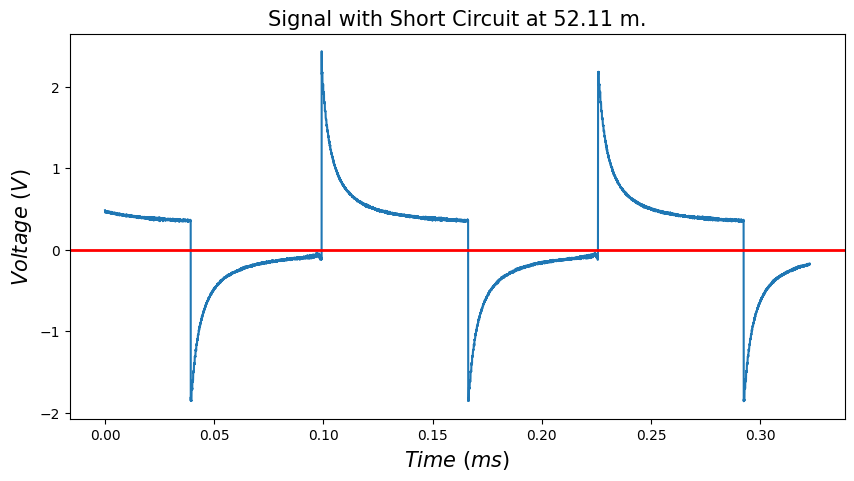

In [3]:
short_52m_files_dir = './data/short-circuit/52m'

#load a random file
v_short_52m = ut.random_file_load(short_52m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_52m, 'Signal with Short Circuit at 52.11 m.')

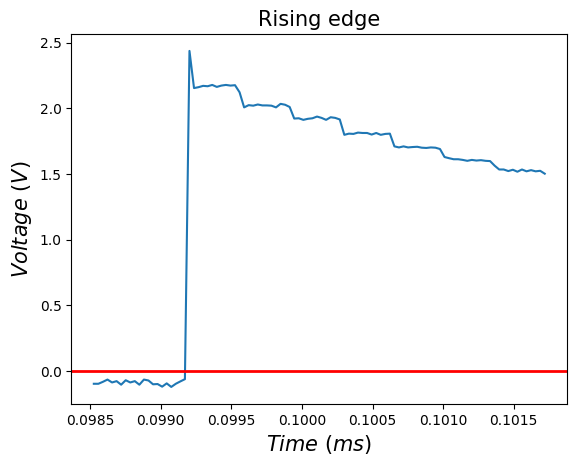

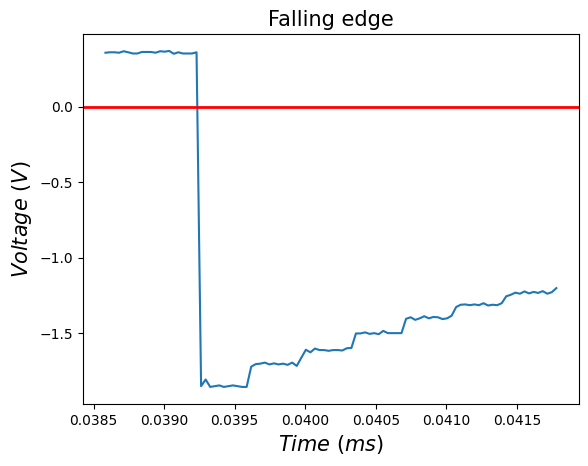

In [4]:
#locate rising a rising edge and a falling edge in the signal
_num_edges = 1
short_52m_edges_indices = ut.edges_detection(v_short_52m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_52m, t, short_52m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

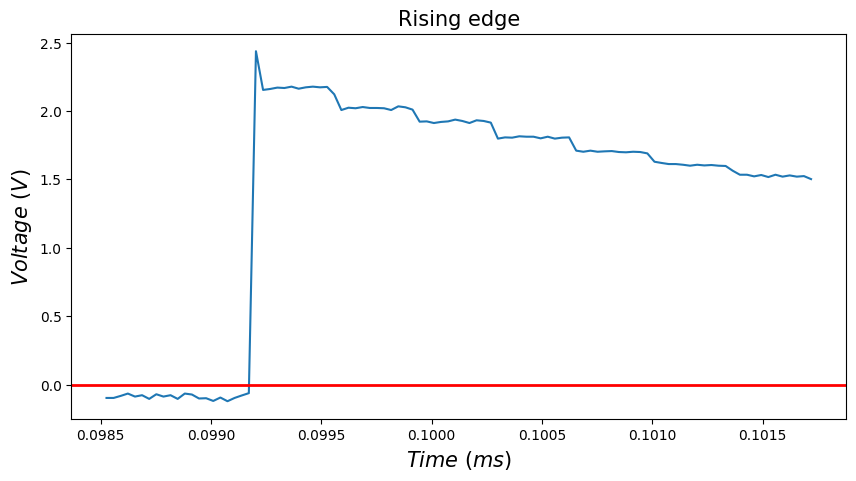

In [5]:
rising_edge_indx = short_52m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_52m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

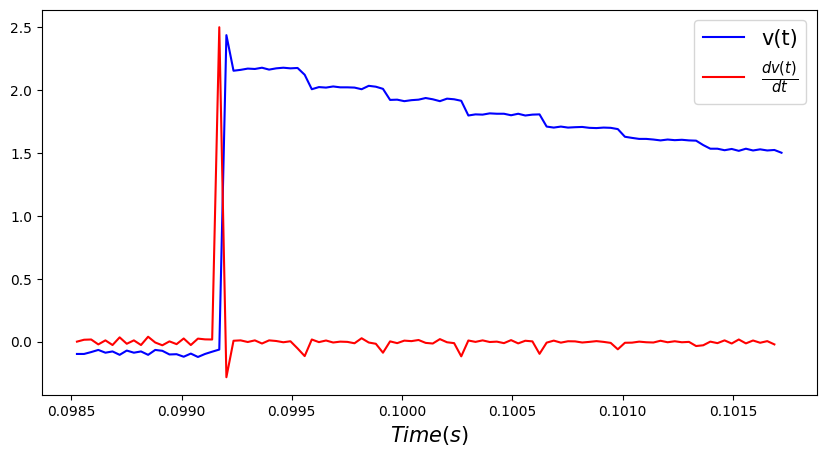

In [6]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

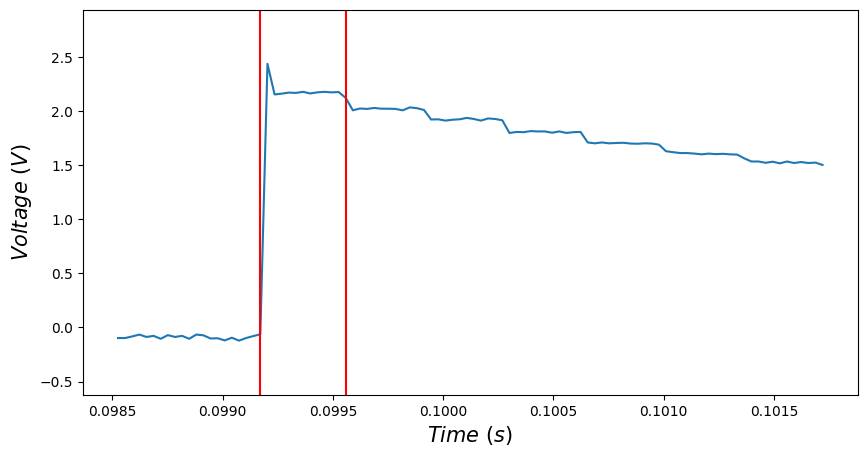

Timed delay is 0.00038713548774231554 ms


In [7]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [8]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 56.827618245694495 m


In [9]:
#model performance
performance = ut.performance_metrics(52.11, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=22.25592191210961, rmse=4.717618245694496)


#### 2. Falling edge

Change point detection on a falling edge

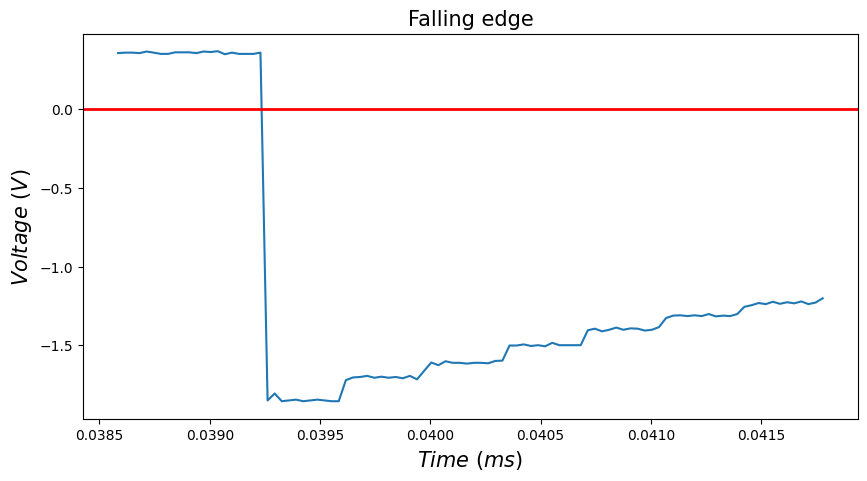

In [10]:
falling_edge_indx = short_52m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_52m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

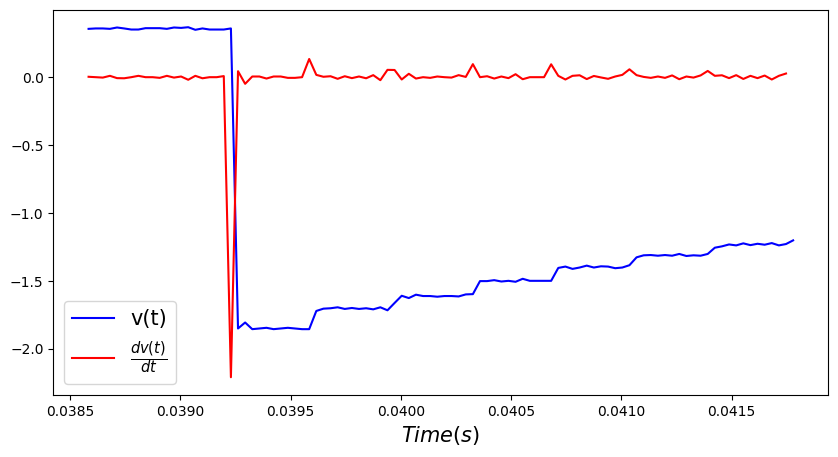

In [11]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

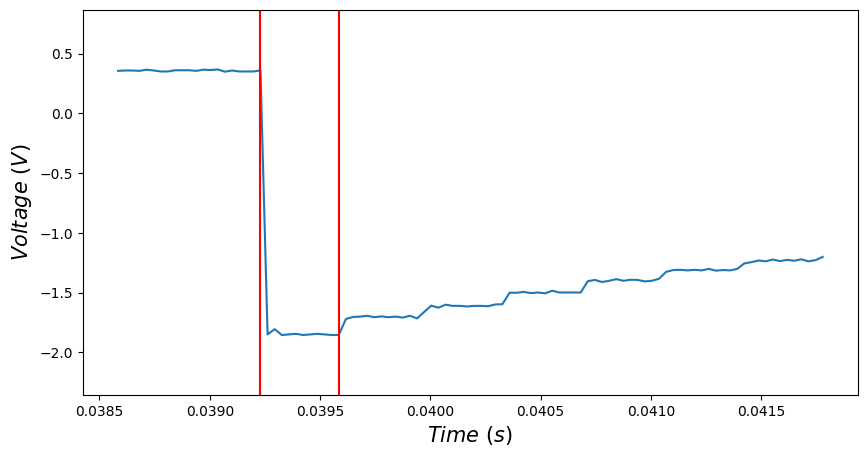

Timed delay is 0.0003548741970971353 ms


In [12]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [13]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 52.09198339188849 m


In [14]:
#model performance
performance = ut.performance_metrics(52.11, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=0.0003245981678436904, rmse=0.018016608111508958)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [15]:
#locate rising rising edges and a falling edges in the signal
short_52m_edges_indices = ut.edges_detection(v_short_52m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_52m_edges_indices)

{'rising_edges': [6996, 3074], 'falling_edges': [1216, 9063, 5153]}


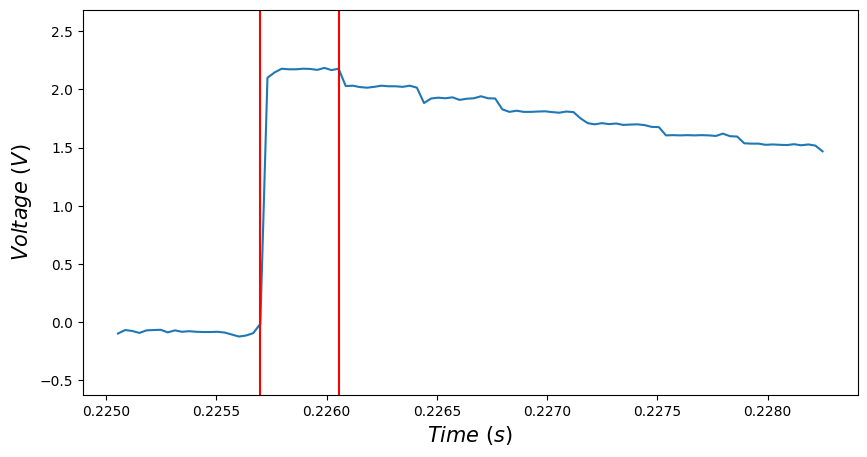

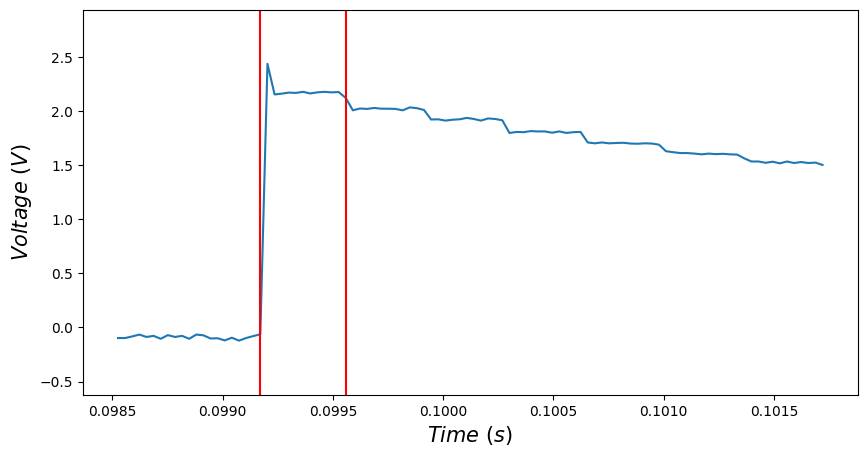

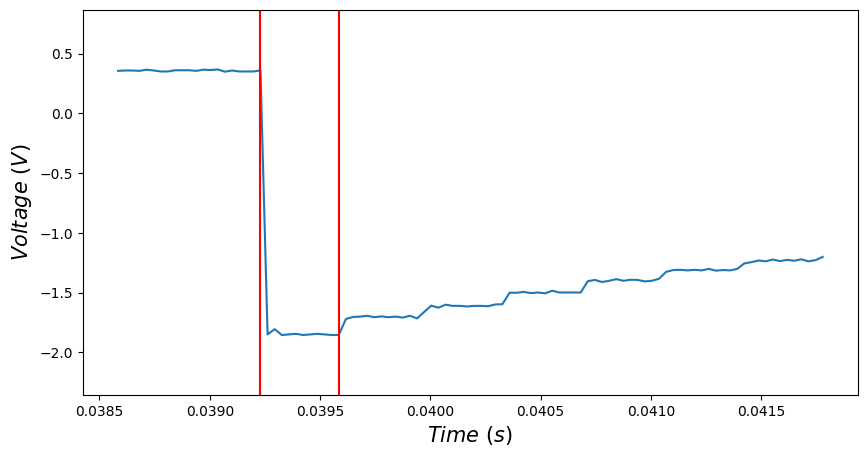

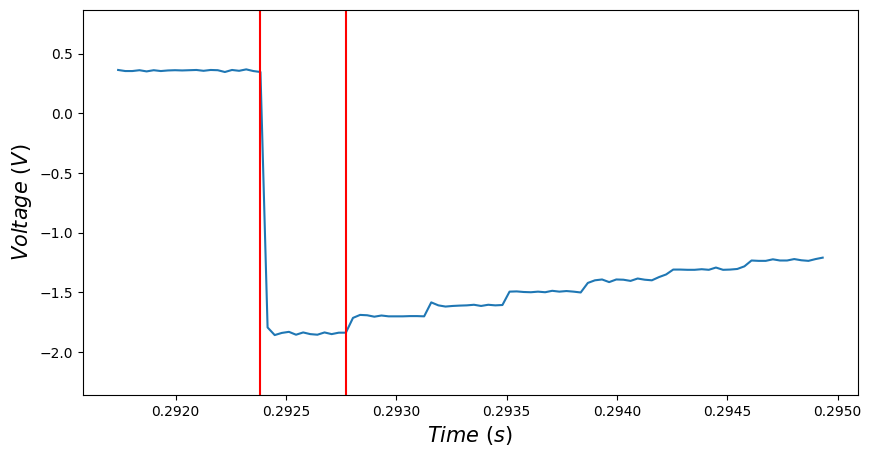

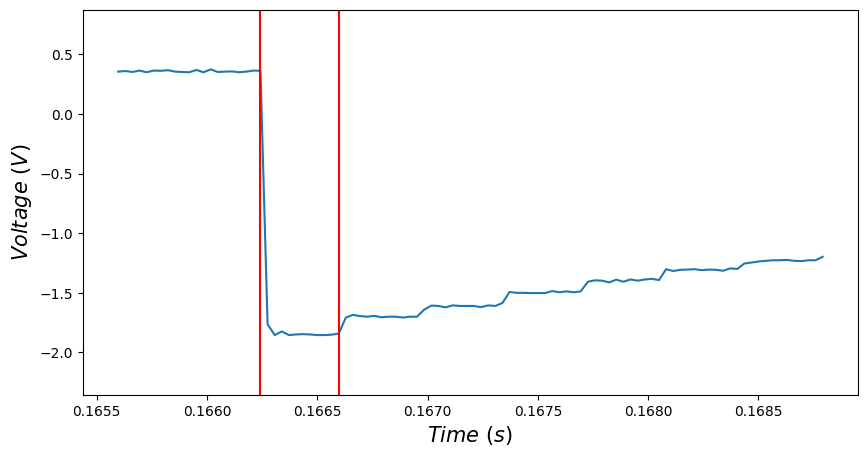

[0.00035487 0.00035487 0.00035487 0.00035487 0.00035487]
Average time delay is 0.00035487419709714083 ms


In [16]:
avg_t_short_52m_delay,  t_short_52m_delays = ut.avg_delay(short_52m_edges_indices, win_size, v_short_52m, t, prior_samples)

print(t_short_52m_delays)
print('Average time delay is {} ms'.format(avg_t_short_52m_delay))

In [17]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_52m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 52.09198339188931 m


In [18]:
#model performance
performance = ut.performance_metrics(52.11, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=0.00032459816781424676, rmse=0.018016608110691834)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [19]:
short_52m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_52m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_52m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_52m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_52m_edges_indices = ut.edges_detection(v_short_52m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_52m_delay,  t_short_52m_delays = ut.avg_delay(short_52m_edges_indices, win_size, v_short_52m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_52m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_52m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(52.11)
        
short_52m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_52m = pd.DataFrame(short_52m_circuit_files)
        
df_short_52m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/52m/short-106-52-1.csv,0.000355,52.091983
1,./data/short-circuit/52m/short-106-52-10.csv,0.000355,52.091983
2,./data/short-circuit/52m/short-106-52-11.csv,0.000355,52.091983
3,./data/short-circuit/52m/short-106-52-13.csv,0.000355,52.091983
4,./data/short-circuit/52m/short-106-52-14.csv,0.000355,52.091983
5,./data/short-circuit/52m/short-106-52-16.csv,0.000355,52.091983
6,./data/short-circuit/52m/short-106-52-17.csv,0.000355,52.091983
7,./data/short-circuit/52m/short-106-52-18.csv,0.000355,52.091983
8,./data/short-circuit/52m/short-106-52-19.csv,0.000355,52.091983
9,./data/short-circuit/52m/short-106-52-2.csv,0.000355,52.091983


In [20]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=0.0003245981678717685, rmse=0.018016608112288186, mae=0.018016608112288186, irm=1.0)


### 57.08 m
Short circuit at 57.08 m from the input port

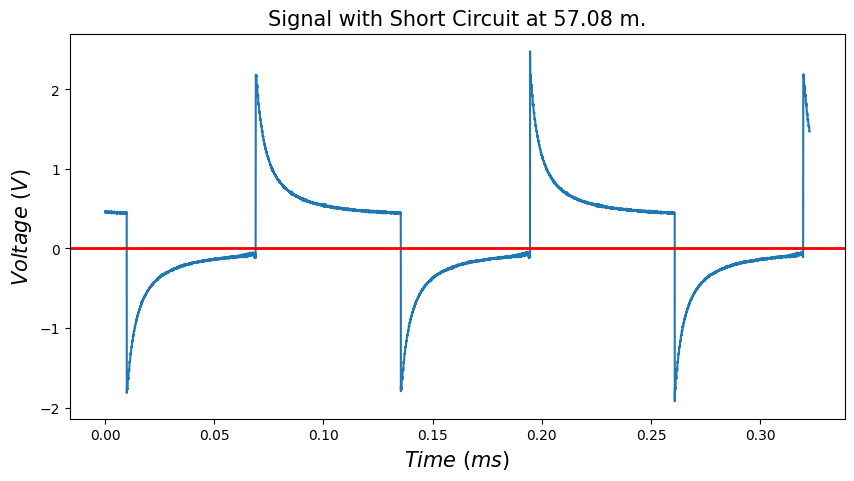

In [21]:
short_57m_files_dir = './data/short-circuit/57m'

#load a random file
v_short_57m = ut.random_file_load(short_57m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_57m, 'Signal with Short Circuit at 57.08 m.')

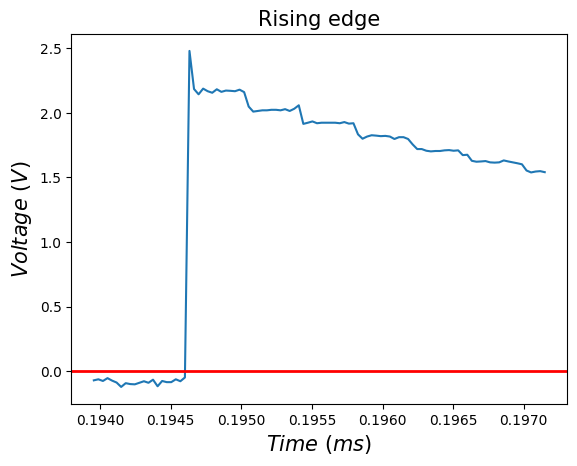

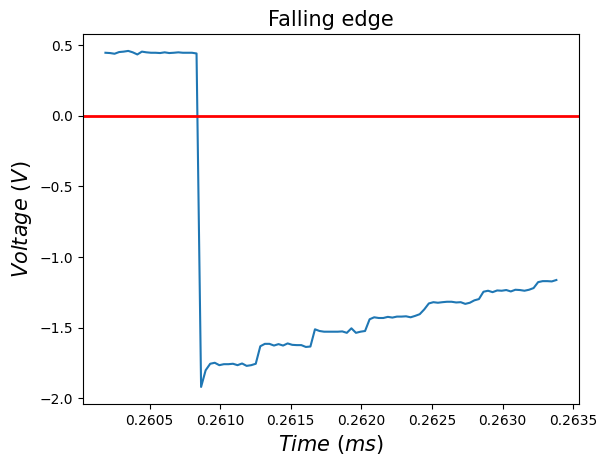

In [22]:
#locate rising a rising edge and a falling edge in the signal
short_57m_edges_indices = ut.edges_detection(v_short_57m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_57m, t, short_57m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

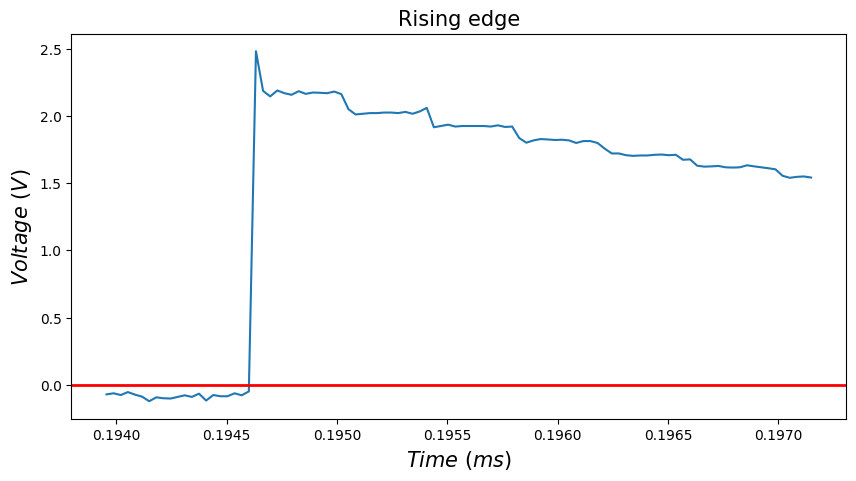

In [23]:
rising_edge_indx = short_57m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_57m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

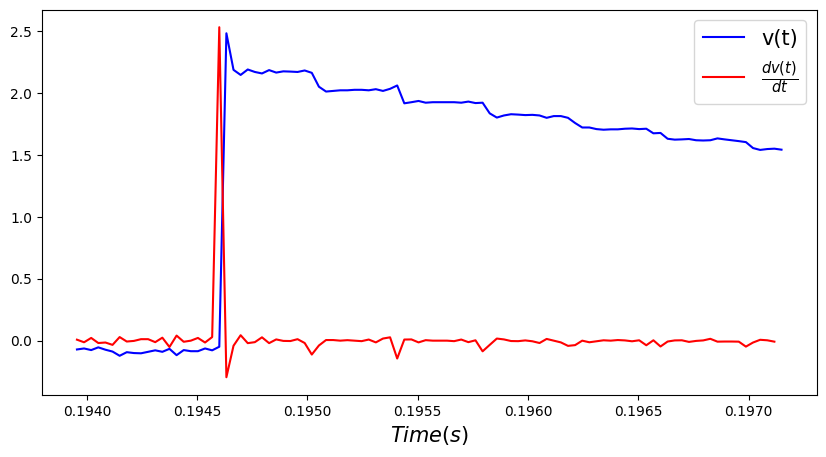

In [24]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

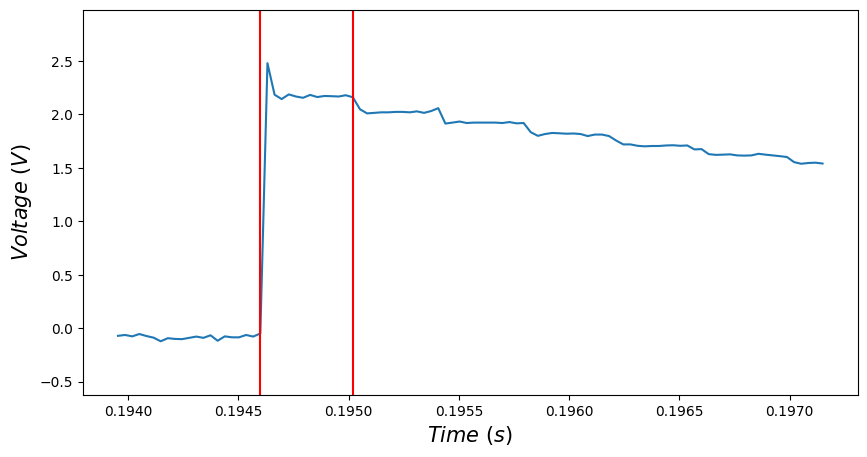

Timed delay is 0.00041939677838750966 ms


In [25]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [26]:
p_rising_fault = ut.fault_point(t_rising_delay, c, vf)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 61.563253099502546 m


In [27]:
#model performance
performance = ut.performance_metrics(57.08, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)


Model performance metrics outcome for a single rising edge: Metrics(mse=20.099558354199203, rmse=4.483253099502548)


#### 2. Falling edge

Change point detection on a falling edge

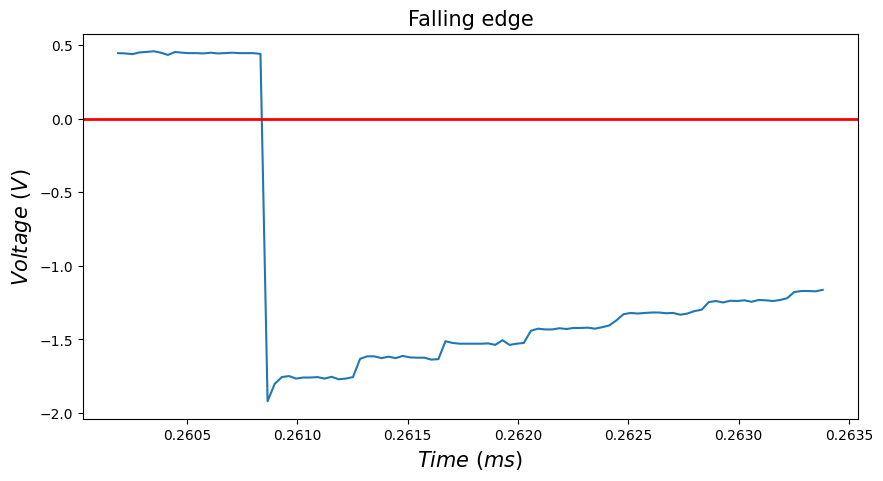

In [28]:
falling_edge_indx = short_57m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_57m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

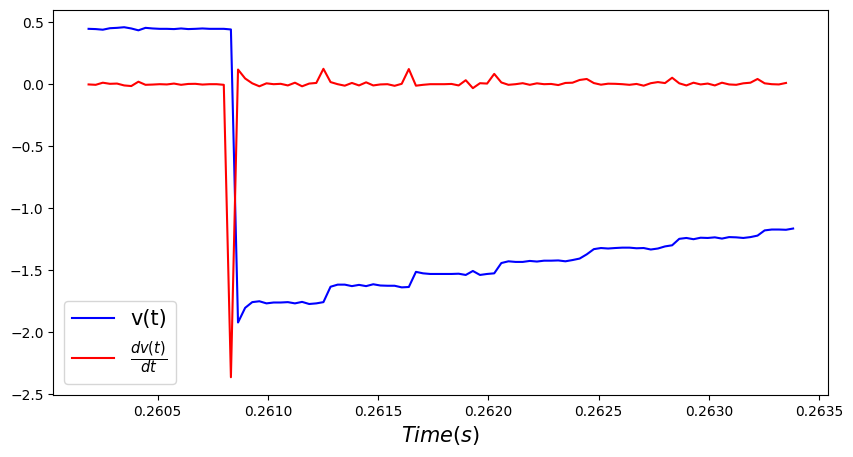

In [29]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

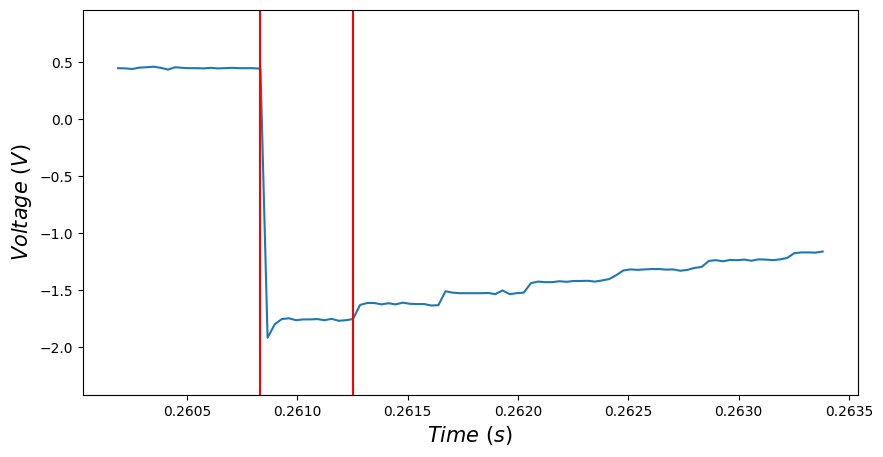

Timed delay is 0.0004193967783875374 ms


In [30]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [31]:
p_falling_fault = ut.fault_point(t_falling_delay, c, vf)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 61.56325309950662 m


In [32]:
#model performance
performance = ut.performance_metrics(57.08, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=20.099558354235707, rmse=4.483253099506619)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [33]:
#locate rising rising edges and a falling edges in the signal
short_57m_edges_indices = ut.edges_detection(v_short_57m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_57m_edges_indices)

{'rising_edges': [2138, 6032], 'falling_edges': [8085, 308, 4198]}


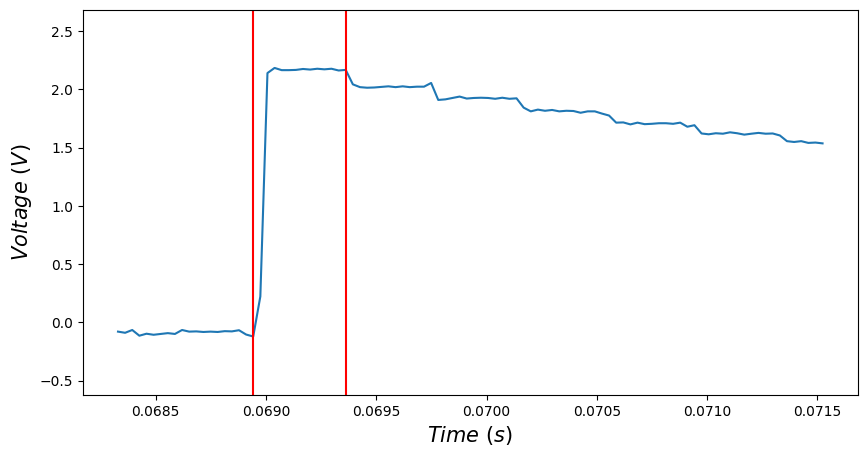

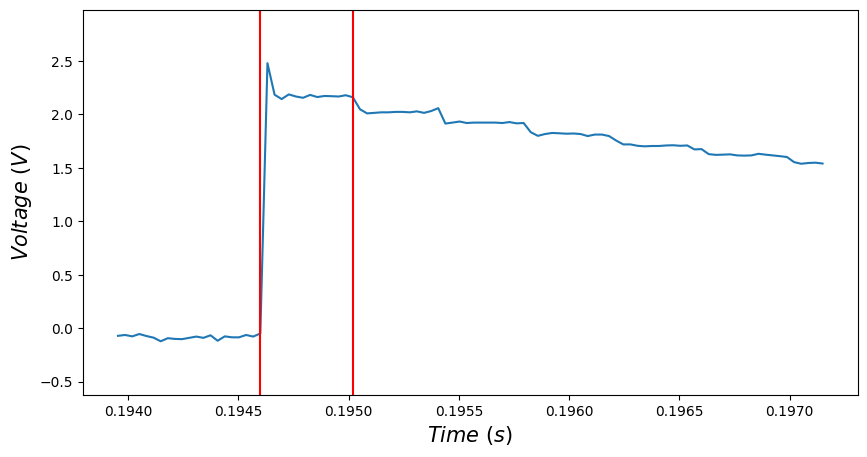

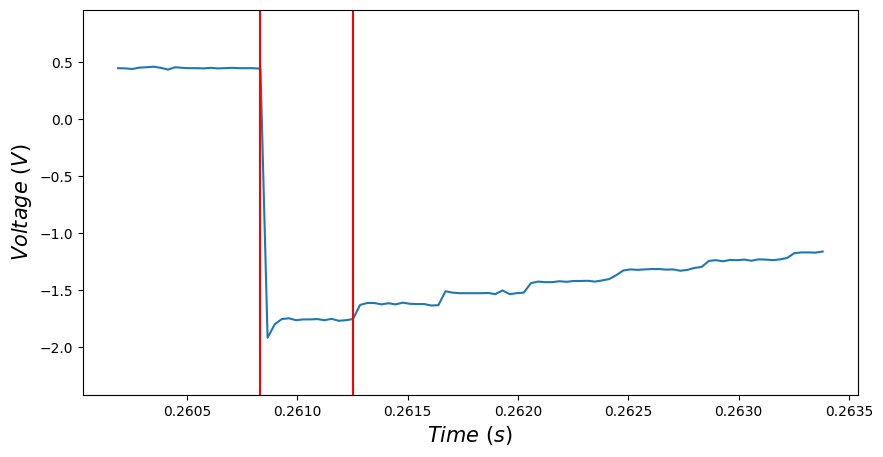

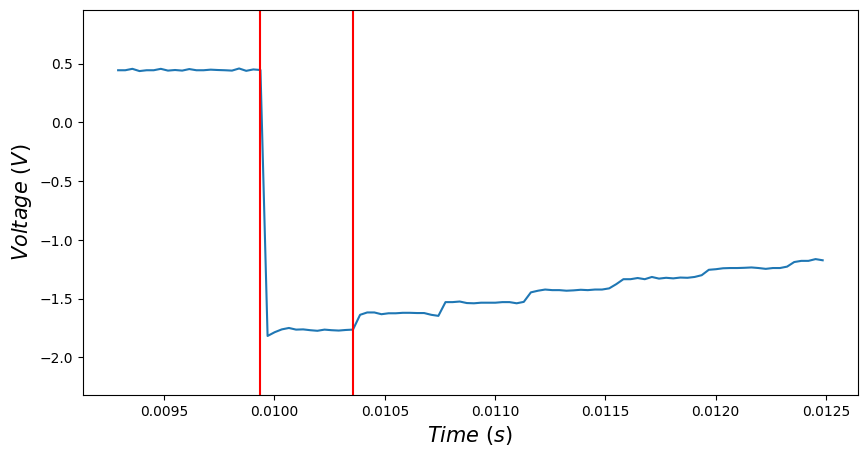

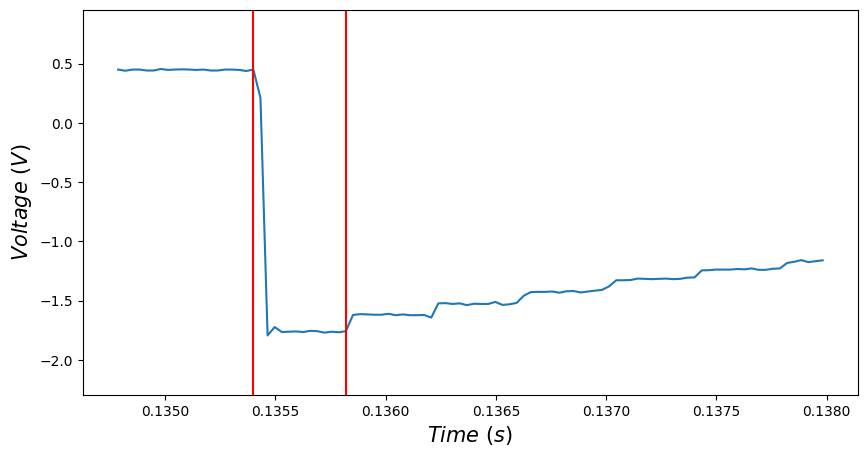

[0.0004194 0.0004194 0.0004194 0.0004194 0.0004194]
Average time delay is 0.00041939677838752213 ms


In [34]:
avg_t_short_57m_delay,  t_short_57m_delays = ut.avg_delay(short_57m_edges_indices, win_size, v_short_57m, t, prior_samples)

print(t_short_57m_delays)
print('Average time delay is {} ms'.format(avg_t_short_57m_delay))

In [35]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_57m_delay, c, vf)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 61.56325309950437 m


In [36]:
#model performance
performance = ut.performance_metrics(57.08, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=20.099558354215578, rmse=4.483253099504374)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [37]:
short_57m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_57m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_57m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_57m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_57m_edges_indices = ut.edges_detection(v_short_57m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_57m_delay,  t_short_57m_delays = ut.avg_delay(short_57m_edges_indices, win_size, v_short_57m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_57m_delay, c, vf)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_57m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(57.08)
        
short_57m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_57m = pd.DataFrame(short_57m_circuit_files)
        
df_short_57m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/57m/short-106-57-1.csv,0.000387,56.827618
1,./data/short-circuit/57m/short-106-57-10.csv,0.000387,56.827618
2,./data/short-circuit/57m/short-106-57-11.csv,0.000387,56.827618
3,./data/short-circuit/57m/short-106-57-12.csv,0.000387,56.827618
4,./data/short-circuit/57m/short-106-57-13.csv,0.000387,56.827618
5,./data/short-circuit/57m/short-106-57-14.csv,0.000387,56.827618
6,./data/short-circuit/57m/short-106-57-15.csv,0.000387,56.827618
7,./data/short-circuit/57m/short-106-57-16.csv,0.000419,61.563253
8,./data/short-circuit/57m/short-106-57-17.csv,0.000419,61.563253
9,./data/short-circuit/57m/short-106-57-18.csv,0.000387,56.827618


In [38]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=2.795859523220329, rmse=1.6720823912775138, mae=0.8293187559233488, irm=1.0)
